## 09. 분류 실습 - 캐글 신용카드 사기 검출

- 1 사기, (0,1 퍼)
- 일반적으로 사기/이상 검출(fraud/anomaly detection)은 레이블 불균형한 분포
- 정상 레이블로 치우친 학습할 수 있음 레이블마다 데이터를 비슷한 수준으로 맞춰 -> 오버 샘플링/언더 샘플링 
- 오버 샘플링: 많은 레이블 데이터를 적은 데이터 수준으로 감소시킴
    - 그냥 동일 데이터를 증식 시키면 과적합 될 수 있어서 피처 약간만 변경해서 증식함.(SMOTE (Syntehtic Minority Over-sampling Technique))
- 언더 샘플링: 적은 레이블 데이터를 많은 데이터 수준으로 증식

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv("data/creditcard.csv")
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [2]:
card_df.info() # null 없음, float열 30, int 열 1 (Class)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [3]:
card_df["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [4]:
from sklearn.model_selection import train_test_split

def get_preprocessed_df(df = None):
    df_copy = df.copy()
    df_copy.drop("Time", axis = 1, inplace = True)
    return df_copy

def get_train_test_dataset(df = None):
    df_copy = get_preprocessed_df(df)

    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]

    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.3, random_state = 0, stratify = y_target)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)


In [5]:
# 레이블 분포 비교 (stratify 로 잘 분할이 되었나)
print("TRAIN\n", y_train.value_counts()/y_train.shape[0])
print("TEST\n", y_test.value_counts()/y_test.shape[0])


TRAIN
 0    0.998275
1    0.001725
Name: Class, dtype: float64
TEST
 0    0.998268
1    0.001732
Name: Class, dtype: float64


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, pred = None, pred_proba = None):
    print("confusion_matrix")
    print(confusion_matrix(y_test, pred), "\n")
    print("auccracy: {0:.3f}, precision: {1:.3f}, recall: {2:.3f}, f1: {3:.3f}, roc_auc: {4:.3f}".format(accuracy_score(y_test,pred), precision_score(y_test, pred), recall_score(y_test, pred), f1_score(y_test, pred), roc_auc_score(y_test,pred_proba)))


lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, lr_pred, lr_pred_proba)


confusion_matrix
[[85279    16]
 [   59    89]] 

auccracy: 0.999, precision: 0.848, recall: 0.601, f1: 0.704, roc_auc: 0.955


In [7]:
# 모델에 따라 핏 예측 성능평가
def get_model_train_eval(model, ftr_train = None, ftr_test = None, tgt_train = None, tgt_test = None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]

    get_clf_eval(tgt_test, pred, pred_proba)


In [8]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = 1, boost_from_average = False)
# 레이블이 불균형해서 boost from average = false 안하면 성능(recall, auc) 낮게 나올 수 있음
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)
# recall, auc 높아짐 

confusion_matrix
[[85290     5]
 [   36   112]] 

auccracy: 1.000, precision: 0.957, recall: 0.757, f1: 0.845, roc_auc: 0.979


<AxesSubplot:xlabel='Amount', ylabel='Density'>

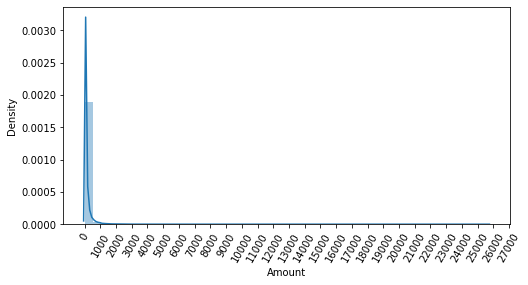

In [9]:
import seaborn as sns
plt.figure(figsize = (8, 4))
plt.xticks(range(0, 30000, 1000), rotation = 60)
sns.distplot(card_df["Amount"])
# 중요 피처인 Amount 의 분포도 확인


In [10]:
from sklearn.preprocessing import StandardScaler

# Amount 를 표준 정규 분포 형태로 변환
def get_preprocessed_df(df = None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy["Amount"].values.reshape(-1, 1))
    df_copy.insert(0, "Amount_Scaled", amount_n)
    df_copy.drop(["Time", "Amount"], axis = 1, inplace = True)
    return df_copy
    

In [11]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print("Logistic Regression")
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

print("\nLightBoostModel")
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)
# 별로 개선 안됨

Logistic Regression
confusion_matrix
[[85281    14]
 [   58    90]] 

auccracy: 0.999, precision: 0.865, recall: 0.608, f1: 0.714, roc_auc: 0.970

LightBoostModel
confusion_matrix
[[85290     5]
 [   37   111]] 

auccracy: 1.000, precision: 0.957, recall: 0.750, f1: 0.841, roc_auc: 0.978


In [12]:
# Amount 를 로그 변환
def get_preprocessed_df(df = None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = np.log1p(df_copy["Amount"])
    df_copy.insert(0, "Amount_Scaled", amount_n)
    df_copy.drop(["Time", "Amount"], axis = 1, inplace = True)
    return df_copy


In [13]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print("Logistic Regression")
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

print("\nLightBoostModel")
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)
# 약간 성능 향상


Logistic Regression
confusion_matrix
[[85283    12]
 [   59    89]] 

auccracy: 0.999, precision: 0.881, recall: 0.601, f1: 0.715, roc_auc: 0.973

LightBoostModel
confusion_matrix
[[85290     5]
 [   35   113]] 

auccracy: 1.000, precision: 0.958, recall: 0.764, f1: 0.850, roc_auc: 0.980


### 이상치 데이터 제거 후 모델 학습/예측/평가

- 전체 데이터 패턴에서 벗어난 데이터 있으면 모델 성능 영향 줄 수 있음.
- IQR(Inter Quantile Range) 


<AxesSubplot:>

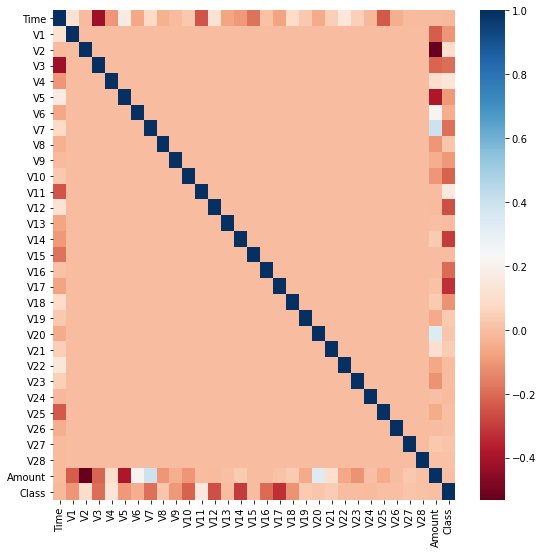

In [14]:
plt.figure(figsize = (9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap = "RdBu")
# Class 와 상관관계 높은 피처 값 찾기 -> V14, V17


In [15]:
# 칼럼에서 이상치 인덱스 추출
def get_outlier(df = None, column = None, weight = 1.5):
    fraud = df[df["Class"] == 1][column]
    
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)

    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight

    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [16]:
def get_preprocessed_df(df = None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = np.log1p(df_copy["Amount"])
    df_copy.insert(0, "Amount_Scaled", amount_n)
    df_copy.drop(["Time", "Amount"], axis = 1, inplace = True)

    outlier_index = get_outlier(df, "V14", 1.5)
    df_copy.drop(outlier_index, axis = 0, inplace = True) # 이상 행 제거
    return df_copy

outlier_index = get_outlier(card_df, "V14", 1.5)
print("index: ", outlier_index)

index:  Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [17]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print("Logistic Regression")
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

print("\nLightBoostModel")
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

# Logistic Regression
# confusion_matrix
# [[85283    12]
#  [   59    89]] 

# auccracy: 0.999, precision: 0.881, recall: 0.601, f1: 0.715, roc_auc: 0.973

# LightBoostModel
# confusion_matrix
# [[85290     5]
#  [   35   113]] 

# auccracy: 1.000, precision: 0.958, recall: 0.764, f1: 0.850, roc_auc: 0.980

# 둘다 recall 이 증가함

Logistic Regression
confusion_matrix
[[85281    14]
 [   48    98]] 

auccracy: 0.999, precision: 0.875, recall: 0.671, f1: 0.760, roc_auc: 0.974

LightBoostModel
confusion_matrix
[[85290     5]
 [   25   121]] 

auccracy: 1.000, precision: 0.960, recall: 0.829, f1: 0.890, roc_auc: 0.978


### SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

- 학습 데이터 세트만 오버 샘플링 해야됨.


In [18]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 0)

X_train_over, y_train_over = smote.fit_sample(X_train, y_train)

print("before smote:", X_train.shape, y_train.shape)
print("after smote:", X_train_over.shape, y_train_over.shape)
print("after smote label::\n", pd.Series(y_train_over).value_counts())

before smote: (199362, 29) (199362,)
after smote: (398040, 29) (398040,)
after smote label::
 1    199020
0    199020
Name: Class, dtype: int64


In [19]:
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train_over, X_test, y_train_over, y_test)
# 정밀도 낮아짐

confusion_matrix
[[82937  2358]
 [   11   135]] 

auccracy: 0.972, precision: 0.054, recall: 0.925, f1: 0.102, roc_auc: 0.974


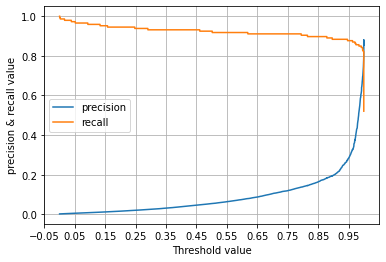

In [20]:
from sklearn.metrics import precision_recall_curve

def precision_recall_curve_plot(y_test, pred_proba_class1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
    plt.plot(thresholds, precisions[:thresholds.shape[0]], label="precision")
    plt.plot(thresholds, recalls[:thresholds.shape[0]], label = "recall")

    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel("Threshold value")
    plt.ylabel("precision & recall value")
    plt.legend()
    plt.grid()
    plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

# 둘다 높을 때가 거의 없어 올바른 예측 모델 생성 안됨

In [21]:
# LightGBM

lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
get_model_train_eval(lgbm_clf, X_train_over, X_test, y_train_over, y_test)
# precision 낮아지고 recall 높아졋음, SMOTE over sampling 적용하면 1 인 학습 데이터가 많으니까 precision 낮아지는게 일반적임

confusion_matrix
[[85283    12]
 [   22   124]] 

auccracy: 1.000, precision: 0.912, recall: 0.849, f1: 0.879, roc_auc: 0.981
